# DATASETS & DATALOADERS
Mã để xử lý các mẫu dữ liệu có thể lộn xộn và khó bảo trì; lý tưởng là chúng tôi muốn mã tập dữ liệu của chúng tôi được tách ra khỏi mã đào tạo mô hình của chúng tôi để có khả năng đọc và mô-đun tốt hơn. PyTorch cung cấp hai gốc dữ liệu: `torch.utils.data.DataLoader` và `torch.utils.data.Dataset` cho phép bạn sử dụng các bộ dữ liệu được tải sẵn cũng như dữ liệu của riêng bạn. `Dataset` lưu trữ các mẫu và nhãn tương ứng của chúng, và `DataLoader` bao bọc một tệp có thể lặp lại xung quanh Tập dữ liệu để cho phép dễ dàng truy cập vào các mẫu.

Thư viện miền PyTorch cung cấp một số bộ dữ liệu được tải sẵn (chẳng hạn như FashionMNIST) phân lớp `torch.utils.data.Dataset` và triển khai các chức năng dành riêng cho dữ liệu cụ thể. Chúng có thể được sử dụng để tạo mẫu và chuẩn mô hình của bạn. Bạn có thể tìm thấy chúng ở đây:  [Image Datasets](https://pytorch.org/vision/stable/datasets.html), [Text Datasets](https://pytorch.org/text/stable/datasets.html), và[ Audio Datasets](https://pytorch.org/audio/stable/datasets.html)

## Loading a Dataset
Đây là một ví dụ về cách tải tập dữ liệu Fashion-MNIST từ TorchVision. Fashion-MNIST là tập dữ liệu về hình ảnh bài viết của Zalando bao gồm 60.000 ví dụ đào tạo và 10.000 ví dụ kiểm tra. Mỗi ví dụ bao gồm một hình ảnh 28 × 28 thang độ xám và một nhãn được liên kết từ một trong 10 lớp.

Chúng tôi tải Tập dữ liệu FashionMNIST với các thông số sau:

- `root` là đường dẫn nơi dữ liệu train/test được lưu trữ,
- `train` chỉ định tập dữ liệu đào tạo hoặc kiểm tra,
- `download = True` tải xuống dữ liệu từ internet nếu nó không có sẵn ở gốc.
- `transform ` và `target_transform` chỉ định các biến đổi đối tượng và nhãn

In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform = ToTensor()
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

0it [00:00, ?it/s]Downloading http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz to data\FashionMNIST\raw\train-images-idx3-ubyte.gz
 99%|█████████▉| 26214400/26421880 [00:12<00:00, 2698391.94it/s]Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw

0it [00:00, ?it/s]Downloading http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz to data\FashionMNIST\raw\train-labels-idx1-ubyte.gz

 56%|█████▌    | 16384/29515 [00:00<00:00, 82160.63it/s]

0it [00:00, ?it/s]Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw


  0%|          | 0/4422102 [00:00<?, ?it/s]

  0%|          | 16384/4422102 [00:00<00:54, 80939.86it/s]

  1%|          | 49152/4422102 [00:00<00:45, 95205.20it/s]

  2%|▏         | 106496/4422102 [00:01<00:36, 118895.11it/s]

  5%|▌         | 221184/4422102 [00:01<00:26, 155714.13it/s]

  8%|▊         | 352256/4422102 [00:01<00:20, 201693.71it/s]


## Lặp lại và hình dung tập dữ liệu
Chúng ta có thể lập chỉ mục `Dataset` theo cách thủ công giống như một danh sách: `training_data[index]`. Chúng tôi sử dụng `matplotlib` để trực quan hóa một số mẫu trong dữ liệu đào tạo của chúng tôi.

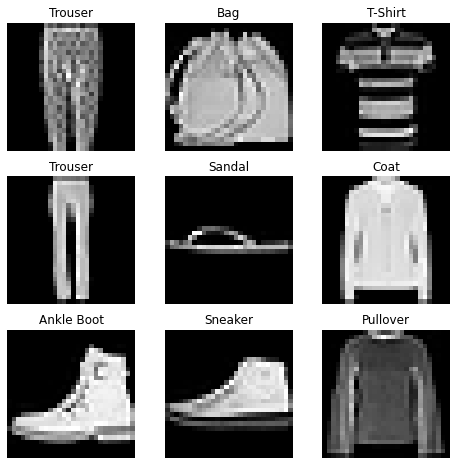

In [4]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols*rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Tạo Tập dữ liệu tùy chỉnh cho các tệp của bạn
Một lớp Tập dữ liệu tùy chỉnh phải triển khai ba hàm: `__init__`, `__len__` và `__getitem__`. Hãy xem cách triển khai này; hình ảnh FashionMNIST được lưu trữ trong thư mục `img_dir` và nhãn của chúng được lưu trữ riêng trong tệp CSV `annotations_file`.

Trong các phần tiếp theo, chúng tôi sẽ phân tích những gì đang xảy ra trong từng chức năng này. 

In [6]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotation_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotation_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform(image):
            label = self.target_transform(label)
        return image, label

## `__init__`
Hàm `__init__` được chạy một lần khi khởi tạo đối tượng `Dataset`. Chúng tôi khởi tạo thư mục chứa hình ảnh, tệp chú thích và cả hai phép biến đổi (được trình bày chi tiết hơn trong phần tiếp theo).

Tệp `label.csv` trông giống như sau:
```
tshirt1.jpg, 0
tshirt2.jpg, 0
......
ankleboot999.jpg, 9
```

```
def __def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform
```

## `__len__`
Hàm `__len__ `trả về số lượng mẫu trong tập dữ liệu của chúng tôi.

Thí dụ:
```
def __len__(self):
    return len(self.img_labels)
```

## __getitem__
Hàm `__getitem__` tải và trả về một mẫu từ tập dữ liệu tại `idx` chỉ mục đã cho. Dựa trên chỉ mục, nó xác định vị trí của hình ảnh trên đĩa, chuyển đổi vị trí đó thành tensor bằng cách sử dụng `read_image`, truy xuất nhãn tương ứng từ dữ liệu csv trong `self.img_labels`, gọi các hàm biến đổi trên chúng (nếu có) và trả về hình ảnh tensor và nhãn tương ứng trong một bộ. 

```
def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label
```

## Chuẩn bị dữ liệu của bạn để đào tạo với DataLoaders
Tập dữ `Dataset` xuất các tính năng của tập dữ liệu của chúng tôi và gắn nhãn từng mẫu một. Trong khi đào tạo một mô hình, chúng tôi thường muốn chuyển các mẫu trong “minibatches”, sắp xếp lại dữ liệu ở mọi kỷ nguyên để giảm bớt việc trang bị mô hình và sử dụng `multiprocessing` (đa xử lý) của Python để tăng tốc độ truy xuất dữ liệu.

`DataLoader` là một công cụ có thể lặp lại, nó sẽ tóm tắt sự phức tạp này cho chúng ta trong một API dễ dàng.

In [8]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## Lặp lại qua DataLoader
Chúng tôi đã tải tập dữ liệu đó vào `Dataloader` và có thể lặp lại qua tập dữ liệu đó nếu cần. Mỗi lần lặp bên dưới trả về một lô `train_features` và `train_labels` (chứa `batch_size = 64` tính năng và nhãn tương ứng). Bởi vì chúng tôi đã chỉ định `shuffle = True`, sau khi chúng tôi lặp lại tất cả các lô, dữ liệu sẽ được xáo trộn (để kiểm soát chi tiết hơn đối với thứ tự tải dữ liệu, hãy xem [Samplers](https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler)).

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


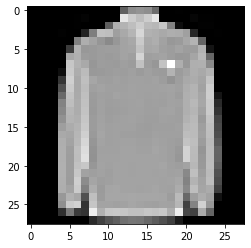

Label: 2


In [9]:
# Display image and label
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## Further Reading
- [`torch.utils.data API`](https://pytorch.org/docs/stable/data.html)